In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pynwb import TimeSeries
from pynwb import NWBHDF5IO
import pandas as pd
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax

# Load Data

In [2]:
import pynwb

data_path = (
    "/stelmo/sam/c3po_datasets/sub-Jenkins_ses-large_desc-train_behavior+ecephys.nwb"
)
io = pynwb.NWBHDF5IO(data_path, "r")
nwbfile = io.read()

/home/sambray/mambaforge-pypy3/envs/spyglass2025/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.4.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [3]:
nwbfile

Data type,object
Shape,"(5,)"
Array size,40.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,0.5
Data type,float64
Shape,"(1453340, 2)"
Array size,22.18 MiB
Chunk shape,None


## Behavior dataframe

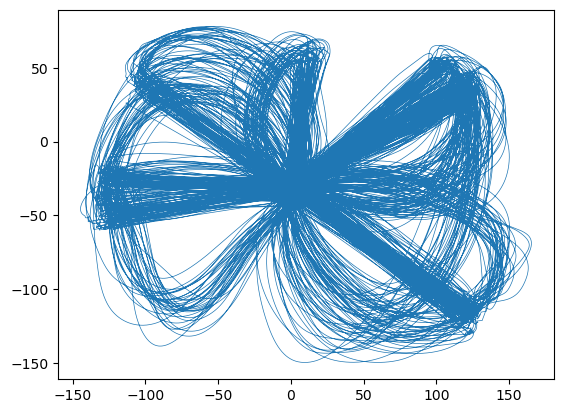

In [4]:
data = []
for object in nwbfile.objects.values():
    if isinstance(object, TimeSeries):
        if "hand" in object.name.lower() or "hand" in object.description.lower():
            data.append(object)
behavior_df = {}
for d in data:
    for i, dim in enumerate(["x", "y"]):
        behavior_df[f"{d.name}_{dim}"] = d.data[:, i]

behavior_df = pd.DataFrame(behavior_df, index=d.get_timestamps())
behavior_df


plt.plot(behavior_df["hand_pos_x"], behavior_df["hand_pos_y"], lw=0.5)
trials_df = nwbfile.trials.to_dataframe()

## Spike Data

In [5]:
# from jax.nn import one_hot

units_df = nwbfile.units.to_dataframe()

t_spike = []
id_spike = []
for i, spikes in enumerate(units_df["spike_times"]):
    t_spike.extend(spikes)
    id_spike.extend([i] * len(spikes))
ind = np.argsort(t_spike)
t_spike = np.array(t_spike)[ind]
id_spike = np.array(id_spike)[ind]

delta_t = np.diff(t_spike) * 1000  # convert to ms
waveforms = id_spike[1:].astype(np.int16)

ind_valid = np.where(delta_t > 0)[0]
delta_t = delta_t[ind_valid]
waveforms = waveforms[ind_valid]

delta_t.shape, waveforms.shape

np.mean(delta_t), np.std(delta_t), (t_spike.max() - t_spike.min()) / 60

(1.6396087204224739, 2.388700701682356, 24.75024888333333)

In [6]:
from spyglass.common.common_interval import Interval

val = trials_df.copy()
# val = val[val.ctr_hold_bump == False]
val = val[val.split != "none"]
val = val[val.split != "none"]
starts = val.move_onset_time.values
rng = (-0.1, 0.5)

valid_times = np.zeros(t_spike.shape[0], dtype=bool)
movement_start_intervals = []
for s in starts:
    if np.isnan(s):
        continue
    movement_start_intervals.append([s + rng[0], s + rng[1]])
    interval = Interval(np.array([[s + rng[0], s + rng[1]]]))
    reach_inds = interval.contains(t_spike, as_indices=True)
    # print(s, reach_inds.size)
    valid_times[reach_inds] = True
movement_start_intervals = Interval(np.array(movement_start_intervals))

[2025-12-11 17:10:59,492][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2025-12-11 17:10:59,525][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


In [15]:
seg_length = 1000
n_overlap = 100
n_segments = (len(delta_t) - seg_length) // n_overlap + 1

delta_t_train = []
waveforms_train = []
for i in range(n_segments):

    start = i * n_overlap
    end = start + seg_length
    # if np.mean(valid_times[start:end]) < 0.5:
    #     continue

    # if np.max(delta_t[start:end] > 20):  # break to exclude trial jumps
    #     continue

    delta_t_train.append(delta_t[start : end - 1])
    waveforms_train.append(waveforms[start : end - 1])
delta_t_train = np.array(delta_t_train, dtype=np.float32)
waveforms_train = np.array(waveforms_train, dtype=np.int16)[..., None]
print(delta_t_train.shape, waveforms_train.shape)

(9048, 999) (9048, 999, 1)


In [ ]:
np.mean(delta_t_train),

(1.4801393,)

# Import C3PO and build model


In [8]:
import os

os.chdir("/home/sambray/Documents/c3po")
from src.c3po.model.model import C3PO

In [23]:
# prep data for model
from src.c3po.model.util import prep_training_data
from src.c3po.model.model import C3PO

keep_params = 0  # True

if keep_params:
    store_params = params.copy()


# hyperparams
latent_dim = 16  # 4
context_dim = 16  # 6


n_neg_samples = 2
encoder_args = dict(
    encoder_model="sorted_spikes",
    n_units=np.max(waveforms),
    gauss_noise_std=0,
    input_format="indices",
)


dilations = [
    1,
    2,
    4,
    8,
]
dilations = dilations * 2
kernels = [
    16,
    16,
    32,
    32,
]
kernels = kernels * 2

context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=50,
    smoothing_decay=1,
    categorical=False,
)

rate_args = dict(
    rate_model="bilinear",
)

distribution = "poisson"
predicted_sequence_length = 1


model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution,
    latent_dim,
    context_dim,
    n_neg_samples,
    predicted_sequence_length,
    return_embeddings_in_call=True,
)


rand_key = jax.random.PRNGKey(0)
params = model.init(
    jax.random.PRNGKey(1), waveforms_train[:2, :300], delta_t_train[:2, :300], rand_key
)
init_params = params.copy()
run_model = jax.jit(model.apply)
if keep_params:
    params = store_params.copy()

# Training

In [ ]:
from src.c3po.model.model import train_model, update_n_neg

params, tracked_loss = train_model(
    model,
    params,
    waveforms_train,
    delta_t_train,
    learning_rate=1e-3,
    n_epochs=1000,
    initial_batch_size=128,
    buffer_size=5,
    min_batch_size=64,
    max_n_neg=64,
    initial_n_neg=8,
)

Epoch 20: 100%|█████████▉| 9024/9048 [00:14<00:00, 620.30samples/s, batch_size=64, loss=3.87, n_neg=64]

Stalled training, no further adjustments possible.


# Create Analysis object and store

In [30]:
from src.c3po.analysis.analysis import C3poAnalysis

analysis_encoder_args = {**encoder_args}
# analysis_encoder_args.update({"gauss_noise_std": 0})
model_args = dict(
    encoder_args=analysis_encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution=distribution,
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=predicted_sequence_length,
    sample_params=None,
)
analysis = C3poAnalysis(model=model, model_args=model_args, params=params)

In [31]:
# embed data and make pca
analysis.embed_data(
    waveforms[None, :, None],
    delta_t[None, :],
    delta_t_units="ms",
    first_mark_time=t_spike[0],
)
t_interp = np.arange(np.min(t_spike), np.max(t_spike), 0.001)
analysis.interpolate_context(t_interp)
analysis.fit_context_pca()

 99%|█████████▉| 900000/905713 [00:01<00:00, 824198.85it/s]


In [28]:
model_name = "monkey_m1pmd_maze_reach_16d"  # _INITIAL"
model_name = "monkey_m1pmd_maze_reach_8d_INITIAL"
model_name = "monkey_m1pmd_maze_reach_16d_50smooth"

from flax import serialization
from src.c3po.tables.dev_tables import C3POStorage

C3POStorage()
insert_key = {
    "model_name": model_name,
    "encoder_args": encoder_args,
    "context_args": context_args,
    "rate_args": rate_args,
    "latent_dim": latent_dim,
    "context_dim": context_dim,
    "learned_params": serialization.to_bytes(params),
    "input_shape": np.array(waveforms_train.shape[-1]),
}

C3POStorage().insert1(insert_key)
analysis.save_embedding(f"/stelmo/sam/c3po_results/{model_name}_embedding.npz")

In [ ]:
(
    C3POStorage()
    & {
        "model_name": model_name,
    }
).delete()

[2025-12-11 18:02:52,153][INFO]: Deleting 1 rows from `sb_c3po`.`c3_p_o_storage`
[2025-12-11 18:02:54,680][INFO]: Deletes committed.


1

([<matplotlib.lines.Line2D at 0x7f023c217250>,
  <matplotlib.lines.Line2D at 0x7f02002c1ed0>],)

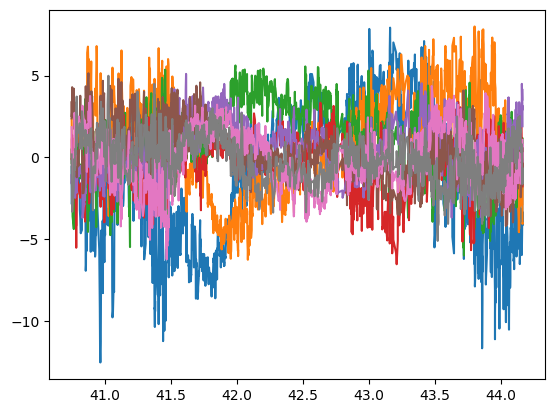

In [32]:
ind = slice(25000, 27000)

plt.plot(analysis.t[ind], analysis.c_pca[ind, :8]),

In [31]:
 analysis.c_pca.shape

(905713, 16)